In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install geopandas
!pip install contextily
!pip install osmnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 47.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.6/99.6 kB 1.4 MB/s eta 0:00:00


In [135]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd
import contextily as ctx
import osmnx as ox

from tqdm import tqdm, tqdm_notebook

from shapely.geometry import Point, MultiPoint
from shapely.ops import nearest_points

from sklearn import model_selection
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.inspection import permutation_importance

# 1. Load Data

In [5]:
df = pd.read_csv('/content/drive/MyDrive/data/projects_public/Healthy_Home/Home_n_Map.csv')
df.head(5)

NO value  NO2 value  PM2p5 value                                geometry  \
0  23.390071  17.539762    17.612700        POINT (-122.3225938 37.80678062)   
1  19.700000  19.956750    15.946719          POINT (-122.32231 37.80614989)   
2  23.611111  23.967768    16.210698        POINT (-122.3223008 37.80642014)   
3  15.714285  18.435184    15.561862  POINT (-122.3222988 37.80587979999999)   
4  27.108695  25.797037    17.120884        POINT (-122.3222671 37.80668898)   

   road_type        zone                                     tract_name  \
0   tertiary  industrial  Census Tract 9819, Alameda County, California   
1  secondary  industrial  Census Tract 9819, Alameda County, California   
2  secondary  industrial  Census Tract 9819, Alameda County, California   
3  secondary  industrial  Census Tract 9819, Alameda County, California   
4  secondary  industrial  Census Tract 9819, Alameda County, California   

        GEOID  state  county   pop_den      wind       temp   Longitude  \
0  6001981900      6       1  8.336845  4.133333  14.950001 -122.322594   
1  6001981900      6       1  8.336845  4.133333  14.950001 -122.322310   
2  6001981900      6       1  8.336845  4.133333  14.950001 -122.322301   
3  6001981900      6       1  8.336845  4.133333  14.950001 -122.322299   
4  6001981900      6       1  8.336845  4.133333  14.950001 -122.322267   

    Latitude Respiratory_HI   Pt_CANCR  
0  37.806781           high  0.7 - 0.8  
1  37.806150           high  0.7 - 0.8  
2  37.806420           high  0.7 - 0.8  
3  37.805880           high  0.7 - 0.8  
4  37.806689           high  0.7 - 0.8

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18286 entries, 0 to 18285
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   NO value        18286 non-null  float64
 1   NO2 value       18286 non-null  float64
 2   PM2p5 value     18286 non-null  float64
 3   geometry        18286 non-null  object 
 4   road_type       18286 non-null  object 
 5   zone            18238 non-null  object 
 6   tract_name      18286 non-null  object 
 7   GEOID           18286 non-null  int64  
 8   state           18286 non-null  int64  
 9   county          18286 non-null  int64  
 10  pop_den         18286 non-null  float64
 11  wind            18270 non-null  float64
 12  temp            18270 non-null  float64
 13  Longitude       18286 non-null  float64
 14  Latitude        18286 non-null  float64
 15  Respiratory_HI  18286 non-null  object 
 16  Pt_CANCR        18286 non-null  object 
dtypes: float64(8), int64(3), object

In [7]:
geo = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude),  crs={'init' :'epsg:4326'})
geo.head(5)

/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


NO value  NO2 value  PM2p5 value                     geometry  road_type  \
0  23.390071  17.539762    17.612700  POINT (-122.32259 37.80678)   tertiary   
1  19.700000  19.956750    15.946719  POINT (-122.32231 37.80615)  secondary   
2  23.611111  23.967768    16.210698   POINT (-122.3223 37.80642)  secondary   
3  15.714285  18.435184    15.561862   POINT (-122.3223 37.80588)  secondary   
4  27.108695  25.797037    17.120884  POINT (-122.32227 37.80669)  secondary   

         zone                                     tract_name       GEOID  \
0  industrial  Census Tract 9819, Alameda County, California  6001981900   
1  industrial  Census Tract 9819, Alameda County, California  6001981900   
2  industrial  Census Tract 9819, Alameda County, California  6001981900   
3  industrial  Census Tract 9819, Alameda County, California  6001981900   
4  industrial  Census Tract 9819, Alameda County, California  6001981900   

   state  county   pop_den      wind       temp   Longitude   Latitude  \
0      6       1  8.336845  4.133333  14.950001 -122.322594  37.806781   
1      6       1  8.336845  4.133333  14.950001 -122.322310  37.806150   
2      6       1  8.336845  4.133333  14.950001 -122.322301  37.806420   
3      6       1  8.336845  4.133333  14.950001 -122.322299  37.805880   
4      6       1  8.336845  4.133333  14.950001 -122.322267  37.806689   

  Respiratory_HI   Pt_CANCR  
0           high  0.7 - 0.8  
1           high  0.7 - 0.8  
2           high  0.7 - 0.8  
3           high  0.7 - 0.8  
4           high  0.7 - 0.8

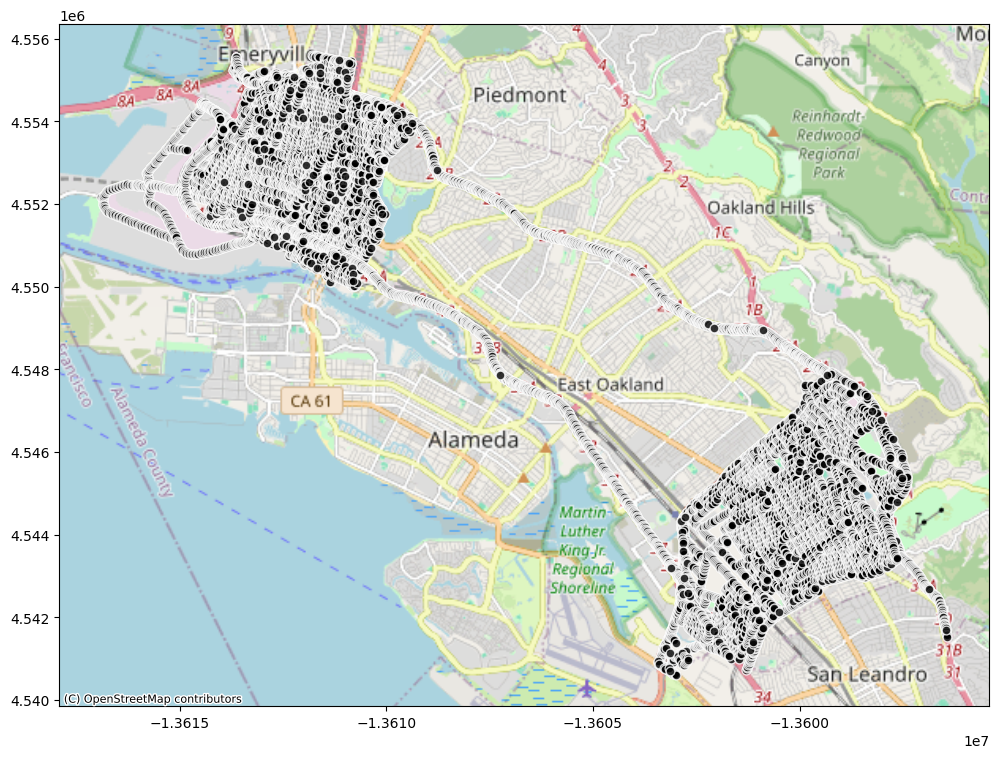

In [8]:
fig, ax = plt.subplots(figsize=(12, 10))
geo.to_crs(epsg=3857).plot(ax=ax, figsize=(12, 12), markersize=40, color='black', alpha=0.8, edgecolor='white')
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
plt.show()


# 2. Data Cleaning


## 2.1. Rename

In [9]:
df = df.rename(columns={'NO value': 'NO', 'NO2 value': 'NO2', 'PM2p5 value': 'PM2p5'})

## 2.2. Drop Irrelevant

In [61]:
df.nunique()

NO                16015
NO2               18226
PM2p5             18281
geometry          18281
road_type             6
zone                  5
tract_name           73
GEOID                73
state                 1
county                1
pop_den              73
wind                 45
temp                 80
Longitude         18129
Latitude          18257
Respiratory_HI        3
Pt_CANCR              3
dtype: int64

In [11]:
# Drop irrelevant features
df_drop = df.drop(['state', 'county', 'tract_name', 'GEOID'], axis=1)

## 2.3. Missing Data

In [12]:
df_drop.isnull().sum()

NO                 0
NO2                0
PM2p5              0
geometry           0
road_type          0
zone              48
pop_den            0
wind              16
temp              16
Longitude          0
Latitude           0
Respiratory_HI     0
Pt_CANCR           0
dtype: int64

In [13]:
# Drop missing data
df_miss = df_drop.dropna(axis=0, subset=['zone', 'wind', 'temp'])

In [14]:
df_miss = df_miss.reset_index()
df_miss = df_miss.drop(['index'], axis=1)

In [15]:
df_miss[df_miss.duplicated()]

NO        NO2      PM2p5                          geometry  \
174   32.059862  24.190178  19.514652   POINT (-122.308528 37.81502824)   
504   16.426667  19.134740  18.727645  POINT (-122.3001287 37.80641093)   
7161  92.638344  45.426999  28.987625   POINT (-122.233788 37.77509246)   

      road_type        zone      pop_den      wind       temp   Longitude  \
174   secondary  industrial   220.026011  4.125000  15.000001 -122.308528   
504   secondary       mixed  3520.358174  4.083333  15.083335 -122.300129   
7161   motorway       mixed  2351.277070  4.091667  15.166668 -122.233788   

       Latitude Respiratory_HI   Pt_CANCR  
174   37.815028           high  0.7 - 0.8  
504   37.806411           high  0.7 - 0.8  
7161  37.775092           high  0.7 - 0.8

## 2.4. Deduplication

In [16]:
# Drop duplicated data
df_dup = df_miss.drop_duplicates()

In [17]:
df_dup.reset_index(inplace=True)
df_dup[df_dup.duplicated()]

Empty DataFrame
Columns: [index, NO, NO2, PM2p5, geometry, road_type, zone, pop_den, wind, temp, Longitude, Latitude, Respiratory_HI, Pt_CANCR]
Index: []

In [18]:
df_out = df_dup.copy()

## 2.5. Outliers

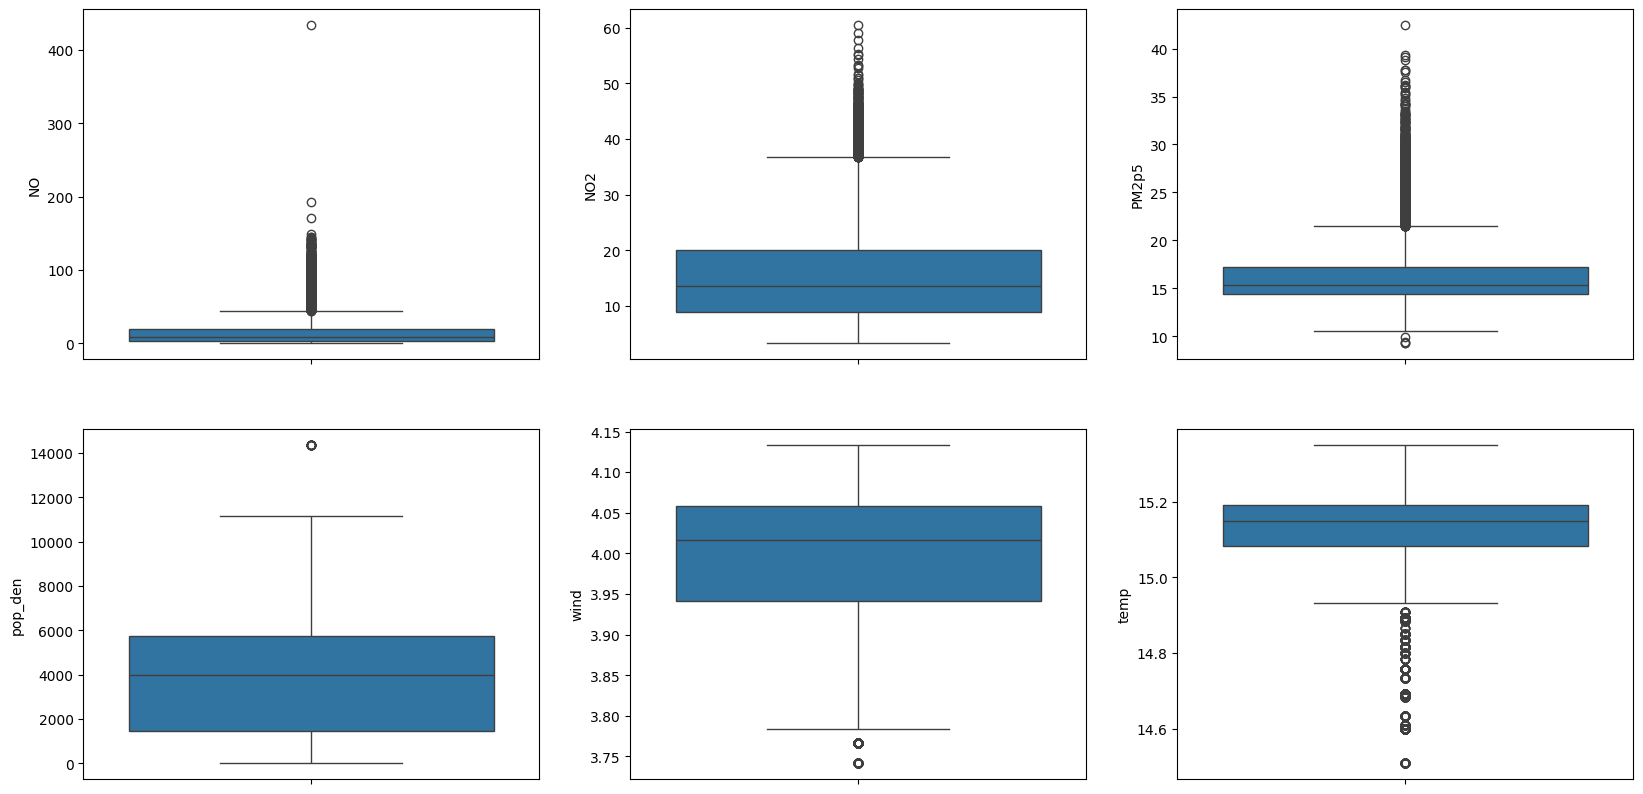

In [19]:
# Outliers
_, axs = plt.subplots(2, 3, figsize=(20, 10))
sns.boxplot(y='NO', data=df_out, ax=axs[0, 0])
sns.boxplot(y='NO2', data=df_out, ax=axs[0, 1])
sns.boxplot(y='PM2p5', data=df_out, ax=axs[0, 2])
sns.boxplot(y='pop_den', data=df_out, ax=axs[1, 0])
sns.boxplot(y='wind', data=df_out, ax=axs[1, 1])
sns.boxplot(y='temp', data=df_out, ax=axs[1, 2])
plt.show()

In [20]:
# Remove outliers
df_out.loc[df_out['NO'] > 200, 'NO'] = 200

In [21]:
df_out.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18219 entries, 0 to 18218
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   index           18219 non-null  int64  
 1   NO              18219 non-null  float64
 2   NO2             18219 non-null  float64
 3   PM2p5           18219 non-null  float64
 4   geometry        18219 non-null  object 
 5   road_type       18219 non-null  object 
 6   zone            18219 non-null  object 
 7   pop_den         18219 non-null  float64
 8   wind            18219 non-null  float64
 9   temp            18219 non-null  float64
 10  Longitude       18219 non-null  float64
 11  Latitude        18219 non-null  float64
 12  Respiratory_HI  18219 non-null  object 
 13  Pt_CANCR        18219 non-null  object 
dtypes: float64(8), int64(1), object(5)
memory usage: 1.9+ MB


In [22]:
df_out.head(2)

index         NO        NO2      PM2p5                          geometry  \
0      0  23.390071  17.539762  17.612700  POINT (-122.3225938 37.80678062)   
1      1  19.700000  19.956750  15.946719    POINT (-122.32231 37.80614989)   

   road_type        zone   pop_den      wind       temp   Longitude  \
0   tertiary  industrial  8.336845  4.133333  14.950001 -122.322594   
1  secondary  industrial  8.336845  4.133333  14.950001 -122.322310   

    Latitude Respiratory_HI   Pt_CANCR  
0  37.806781           high  0.7 - 0.8  
1  37.806150           high  0.7 - 0.8

In [23]:
out_geo = gpd.GeoDataFrame(df_out, geometry=gpd.points_from_xy(df_out.Longitude, df_out.Latitude), crs={'init' :'epsg:4326'})


/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


# 3. Feature Engineering

## 3.1. Oakland

<Axes: >

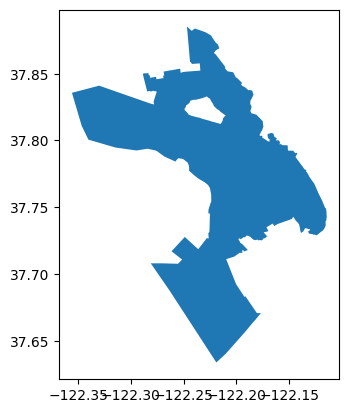

In [62]:
oakland = ox.geocode_to_gdf('Oakland, CA')
oakland.plot()

In [25]:
oakland_geo = gpd.sjoin(out_geo, oakland, how='inner')

<ipython-input-25-58781e7d30eb>:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326

  oakland_geo = gpd.sjoin(out_geo, oakland, how='inner')


In [26]:
oakland_geo.head(2)

index         NO        NO2      PM2p5                     geometry  \
0      0  23.390071  17.539762  17.612700  POINT (-122.32259 37.80678)   
1      1  19.700000  19.956750  15.946719  POINT (-122.32231 37.80615)   

   road_type        zone   pop_den      wind       temp  ...   osm_id  \
0   tertiary  industrial  8.336845  4.133333  14.950001  ...  2833530   
1  secondary  industrial  8.336845  4.133333  14.950001  ...  2833530   

         lat         lon     class            type  place_rank  importance  \
0  37.804456 -122.271356  boundary  administrative          16    0.677822   
1  37.804456 -122.271356  boundary  administrative          16    0.677822   

   addresstype     name                                       display_name  
0         city  Oakland  Oakland, Alameda County, California, United St...  
1         city  Oakland  Oakland, Alameda County, California, United St...  

[2 rows x 31 columns]

In [27]:
oakland_geo.nunique()

index             18217
NO                15961
NO2               18161
PM2p5             18215
geometry          18215
road_type             6
zone                  5
pop_den              70
wind                 45
temp                 80
Longitude         18065
Latitude          18192
Respiratory_HI        3
Pt_CANCR              3
index_right           1
bbox_west             1
bbox_south            1
bbox_east             1
bbox_north            1
place_id              1
osm_type              1
osm_id                1
lat                   1
lon                   1
class                 1
type                  1
place_rank            1
importance            1
addresstype           1
name                  1
display_name          1
dtype: int64

In [28]:
oakland_geo = oakland_geo.drop(['index_right', 'bbox_east', 'bbox_north', 'bbox_south', 'bbox_west'], axis=1)

## 3.2. Roads

In [29]:
oak_streets = ox.graph_from_place('Oakland, CA', network_type='drive')
nodes, edges = ox.graph_to_gdfs(oak_streets)

<Axes: >

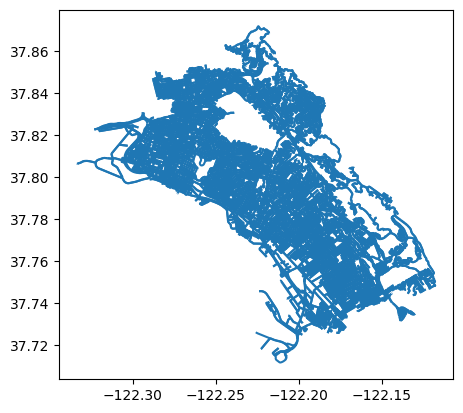

In [30]:
edges.plot()

In [31]:
oak_roads = edges.copy()

In [32]:
oak_roads['highway'].value_counts()

highway
residential                        14791
secondary                           2899
tertiary                            2583
primary                              777
motorway_link                        320
unclassified                         236
motorway                             208
secondary_link                        97
trunk                                 63
trunk_link                            39
tertiary_link                         39
living_street                         24
primary_link                          14
[residential, unclassified]            4
[living_street, residential]           2
[motorway_link, motorway]              2
[motorway_link, secondary_link]        2
road                                   2
Name: count, dtype: int64

In [33]:
# Clean
oak_roads['highway'] = oak_roads['highway'].str.replace('_link', '')
oak_roads['highway'] = np.where(oak_roads['highway'] == 'trunk', 'secondary', oak_roads['highway'])
oak_roads['highway'] = np.where(oak_roads['highway'] == 'living_street', 'residential', oak_roads['highway'])
oak_roads['highway'] = np.where(oak_roads['highway'] == 'road', 'residential', oak_roads['highway'])

oak_roads['highway'].value_counts()

highway
residential     14817
secondary        3098
tertiary         2622
primary           791
motorway          528
unclassified      236
Name: count, dtype: int64

<Axes: xlabel='highway', ylabel='count'>

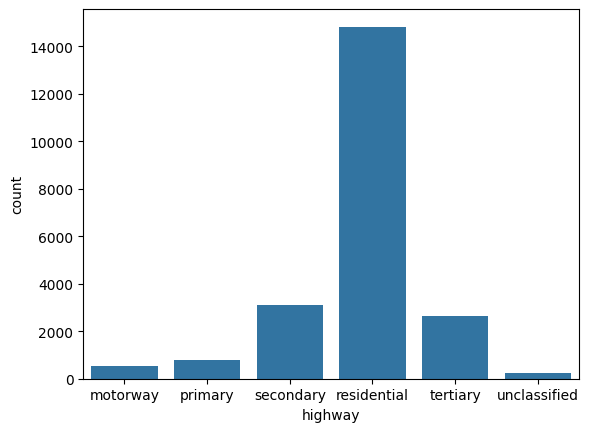

In [34]:
sns.countplot(x='highway', data=oak_roads)

In [35]:
oak_highways = oak_roads[oak_roads.highway == 'motorway']
oak_primary = oak_roads[oak_roads.highway == 'primary']
oak_secondary = oak_roads[oak_roads.highway == 'secondary']
oak_tertiary = oak_roads[oak_roads.highway == 'tertiary']
oak_resid = oak_roads[oak_roads.highway == 'residential']

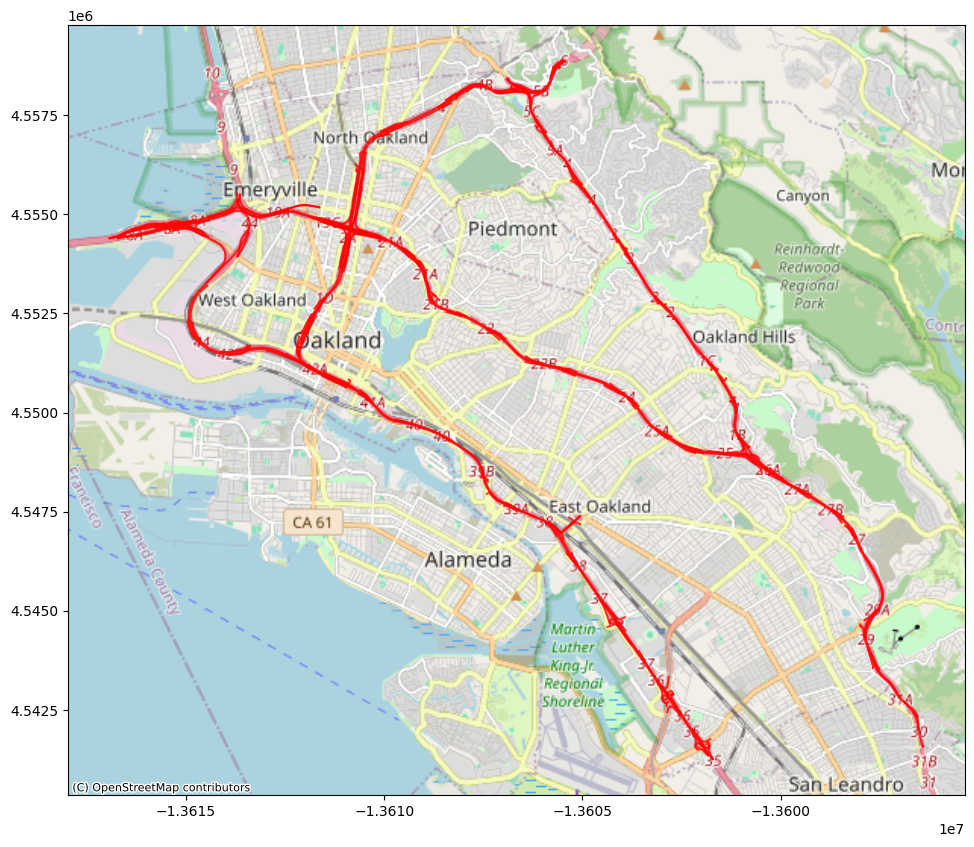

In [36]:
# Highways
fig, ax = plt.subplots(figsize=(12, 10))
oak_highways.to_crs(epsg=3857).plot(ax=ax, figsize=(12, 12), color='red', alpha=0.8, edgecolor='white')
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

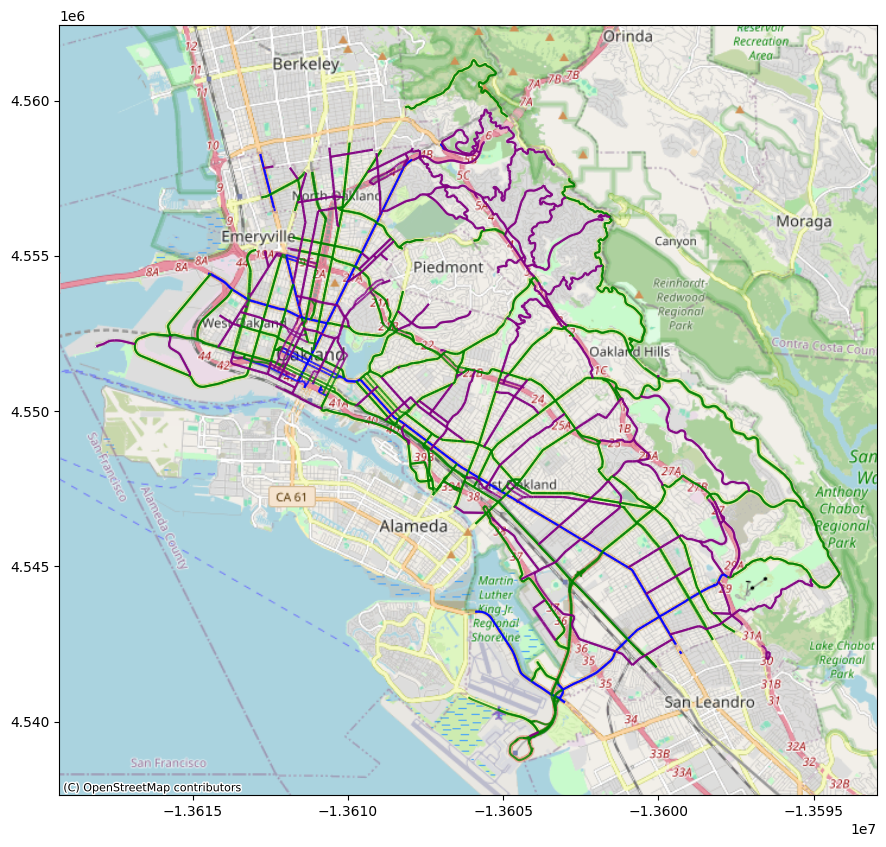

In [37]:
# Primary and secondary and tertiary
fig, ax = plt.subplots(figsize=(12, 10))
oak_primary.to_crs(epsg=3857).plot(ax=ax, figsize=(12, 12), color='blue', alpha=0.8, edgecolor='white')
oak_secondary.to_crs(epsg=3857).plot(ax=ax, figsize=(12, 12), color='green', alpha=0.8, edgecolor='white')
oak_tertiary.to_crs(epsg=3857).plot(ax=ax, figsize=(12, 12), color='purple', alpha=0.8, edgecolor='white')
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

In [38]:
oakland_geo_m = oakland_geo.to_crs({'init': 'epsg:32610'}).copy()
highway_m = oak_highways.to_crs({'init': 'epsg:32610'}).copy()
primary_m = oak_primary.to_crs({'init': 'epsg:32610'}).copy()
secondary_m = oak_secondary.to_crs({'init': 'epsg:32610'}).copy()
tertiary_m = oak_tertiary.to_crs({'init': 'epsg:32610'}).copy()

# distance to roads
def distance_to_roads(gps, road):
  dists = []
  for i in road.geometry:
    dists.append(i.distance(gps))
  return np.min(dists)

/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [39]:
tqdm.pandas()
oakland_geo['closest_highway'] = oakland_geo_m['geometry'].progress_apply(distance_to_roads, road=highway_m)

100%|██████████| 18217/18217 [03:09<00:00, 96.31it/s]


In [40]:
tqdm.pandas()
oakland_geo['closest_primary'] = oakland_geo_m['geometry'].progress_apply(distance_to_roads, road=primary_m)

100%|██████████| 18217/18217 [04:37<00:00, 65.72it/s]


In [41]:
tqdm.pandas()
oakland_geo['closest_secondary'] = oakland_geo_m['geometry'].progress_apply(distance_to_roads, road=secondary_m)

100%|██████████| 18217/18217 [17:00<00:00, 17.86it/s]


In [42]:
tqdm.pandas()
oakland_geo['closest_tertiary'] = oakland_geo_m['geometry'].progress_apply(distance_to_roads, road=tertiary_m)

100%|██████████| 18217/18217 [14:27<00:00, 21.00it/s]


## 3.3. Intersections

In [63]:
nodes['highway'].value_counts()

highway
traffic_signals      790
stop                 354
turning_circle       322
motorway_junction    135
crossing              14
trailhead              3
turning_loop           1
Name: count, dtype: int64

In [64]:
nodes.head(2)

y           x            highway  street_count  ref  \
osmid                                                                   
30362160  37.824005 -122.303118  motorway_junction             3  NaN   
30362888  37.825844 -122.303058  motorway_junction             3   8A   

         junction railway                     geometry  
osmid                                                   
30362160      NaN     NaN    POINT (-122.30312 37.824)  
30362888      NaN     NaN  POINT (-122.30306 37.82584)

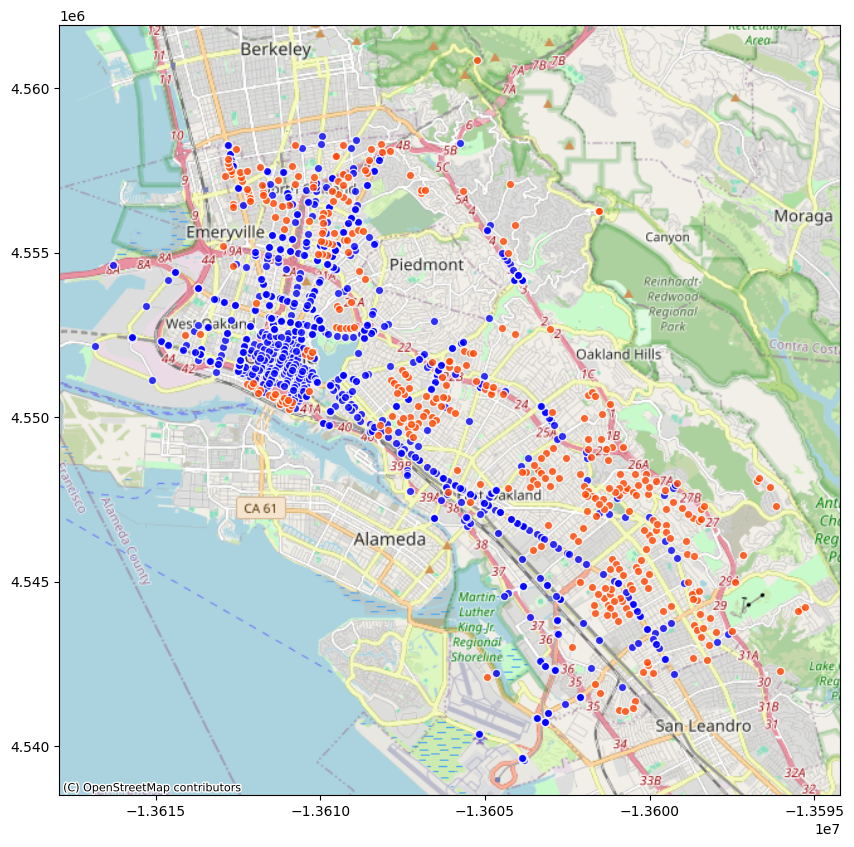

In [66]:
signals = nodes[nodes['highway'] == 'traffic_signals']
stop = nodes[nodes['highway'] == 'stop']

fig, ax = plt.subplots(figsize=(12, 10))
signals.to_crs(epsg=3857).plot(ax=ax, figsize=(12, 12), color='blue', alpha=0.8, edgecolor='white')
stop.to_crs(epsg=3857).plot(ax=ax, figsize=(12, 12), color='orangered', alpha=0.8, edgecolor='white')
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

In [74]:
signals_m = signals.to_crs({'init': 'epsg:32610'}).copy()
stop_m = stop.to_crs({'init': 'epsg:32610'}).copy()

def nearest_intersection(gps, intersections):
  closest = nearest_points(gps, MultiPoint(intersections.values))[1]
  return gps.distance(closest)

/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [75]:
tqdm.pandas()
oakland_geo['traffic_signal_dist'] = oakland_geo_m['geometry'].progress_apply(nearest_intersection, intersections=signals_m['geometry'])

100%|██████████| 18217/18217 [03:25<00:00, 88.47it/s] 


In [76]:
tqdm.pandas()
oakland_geo['stop_sign_dist'] = oakland_geo_m['geometry'].progress_apply(nearest_intersection, intersections=stop_m['geometry'])

100%|██████████| 18217/18217 [01:34<00:00, 192.18it/s]


## 3.4. Encoding

In [77]:
zone = oakland_geo['zone']
road_type = oakland_geo['road_type']

In [78]:
# One-hot encoding
oakland_geo_1 = pd.get_dummies(oakland_geo, columns=['road_type', 'zone'], dtype=int, drop_first=False)

In [79]:
oakland_geo_1.head(2)

index         NO        NO2      PM2p5                     geometry  \
0      0  23.390071  17.539762  17.612700  POINT (-122.32259 37.80678)   
1      1  19.700000  19.956750  15.946719  POINT (-122.32231 37.80615)   

    pop_den      wind       temp   Longitude   Latitude  ...  \
0  8.336845  4.133333  14.950001 -122.322594  37.806781  ...   
1  8.336845  4.133333  14.950001 -122.322310  37.806150  ...   

  road_type_primary road_type_residential  road_type_secondary  \
0                 0                     0                    0   
1                 0                     0                    1   

  road_type_tertiary  road_type_unclassified  zone_commercial  \
0                  1                       0                0   
1                  0                       0                0   

   zone_industrial zone_mixed zone_open_space  zone_residential  
0                1          0               0                 0  
1                1          0               0                 0  

[2 rows x 41 columns]

In [80]:
oakland_geo_1 = pd.concat([oakland_geo_1, zone, road_type], axis=1)
oakland_geo_1.head(2)

index         NO        NO2      PM2p5                     geometry  \
0      0  23.390071  17.539762  17.612700  POINT (-122.32259 37.80678)   
1      1  19.700000  19.956750  15.946719  POINT (-122.32231 37.80615)   

    pop_den      wind       temp   Longitude   Latitude  ...  \
0  8.336845  4.133333  14.950001 -122.322594  37.806781  ...   
1  8.336845  4.133333  14.950001 -122.322310  37.806150  ...   

  road_type_secondary road_type_tertiary  road_type_unclassified  \
0                   0                  1                       0   
1                   1                  0                       0   

  zone_commercial  zone_industrial  zone_mixed  zone_open_space  \
0               0                1           0                0   
1               0                1           0                0   

  zone_residential        zone  road_type  
0                0  industrial   tertiary  
1                0  industrial  secondary  

[2 rows x 43 columns]

## 3.5. Data Preparation

In [81]:
oakland_geo_1.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 18217 entries, 0 to 18218
Data columns (total 43 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   index                   18217 non-null  int64   
 1   NO                      18217 non-null  float64 
 2   NO2                     18217 non-null  float64 
 3   PM2p5                   18217 non-null  float64 
 4   geometry                18217 non-null  geometry
 5   pop_den                 18217 non-null  float64 
 6   wind                    18217 non-null  float64 
 7   temp                    18217 non-null  float64 
 8   Longitude               18217 non-null  float64 
 9   Latitude                18217 non-null  float64 
 10  Respiratory_HI          18217 non-null  object  
 11  Pt_CANCR                18217 non-null  object  
 12  place_id                18217 non-null  int64   
 13  osm_type                18217 non-null  object  
 14  osm_id             

In [82]:
oakland_geo_1 = oakland_geo_1.drop(['index', 'Pt_CANCR'], axis=1)

In [83]:
oakland_geo_1['Respiratory_HI'] = np.where(oakland_geo_1['Respiratory_HI'].str.contains('high'), '3', oakland_geo_1['Respiratory_HI'])
oakland_geo_1['Respiratory_HI'] = np.where(oakland_geo_1['Respiratory_HI'].str.contains('moderate'), '2', oakland_geo_1['Respiratory_HI'])
oakland_geo_1['Respiratory_HI'] = np.where(oakland_geo_1['Respiratory_HI'].str.contains('low'), '1', oakland_geo_1['Respiratory_HI'])
oakland_geo_1['Respiratory_HI'] = oakland_geo_1['Respiratory_HI'].astype(float)

oakland_geo_1.head(2)

NO        NO2      PM2p5                     geometry   pop_den  \
0  23.390071  17.539762  17.612700  POINT (-122.32259 37.80678)  8.336845   
1  19.700000  19.956750  15.946719  POINT (-122.32231 37.80615)  8.336845   

       wind       temp   Longitude   Latitude  Respiratory_HI  ...  \
0  4.133333  14.950001 -122.322594  37.806781             3.0  ...   
1  4.133333  14.950001 -122.322310  37.806150             3.0  ...   

   road_type_secondary road_type_tertiary  road_type_unclassified  \
0                    0                  1                       0   
1                    1                  0                       0   

   zone_commercial  zone_industrial zone_mixed zone_open_space  \
0                0                1          0               0   
1                0                1          0               0   

   zone_residential        zone  road_type  
0                 0  industrial   tertiary  
1                 0  industrial  secondary  

[2 rows x 41 columns]

In [84]:
oakland_geo_1.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 18217 entries, 0 to 18218
Data columns (total 41 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   NO                      18217 non-null  float64 
 1   NO2                     18217 non-null  float64 
 2   PM2p5                   18217 non-null  float64 
 3   geometry                18217 non-null  geometry
 4   pop_den                 18217 non-null  float64 
 5   wind                    18217 non-null  float64 
 6   temp                    18217 non-null  float64 
 7   Longitude               18217 non-null  float64 
 8   Latitude                18217 non-null  float64 
 9   Respiratory_HI          18217 non-null  float64 
 10  place_id                18217 non-null  int64   
 11  osm_type                18217 non-null  object  
 12  osm_id                  18217 non-null  int64   
 13  lat                     18217 non-null  float64 
 14  lon                

In [89]:
# Numerical
numerical = ['NO', 'NO2', 'PM2p5', 'pop_den', 'wind', 'temp', 'closest_highway', 'closest_primary', 'closest_secondary', 'closest_tertiary',
             'traffic_signal_dist', 'stop_sign_dist', 'road_type_motorway', 'road_type_primary', 'road_type_residential', 'road_type_secondary', 'road_type_tertiary',
             'road_type_unclassified', 'zone_commercial', 'zone_industrial', 'zone_mixed', 'zone_open_space', 'zone_residential', 'Longitude', 'Latitude', 'Respiratory_HI']

# Categorical
categorical = ['geometry', 'zone', 'road_type']

# 4. Data Visualization

In [86]:
vis_df = oakland_geo_1.copy()

## 4.1. Correlation

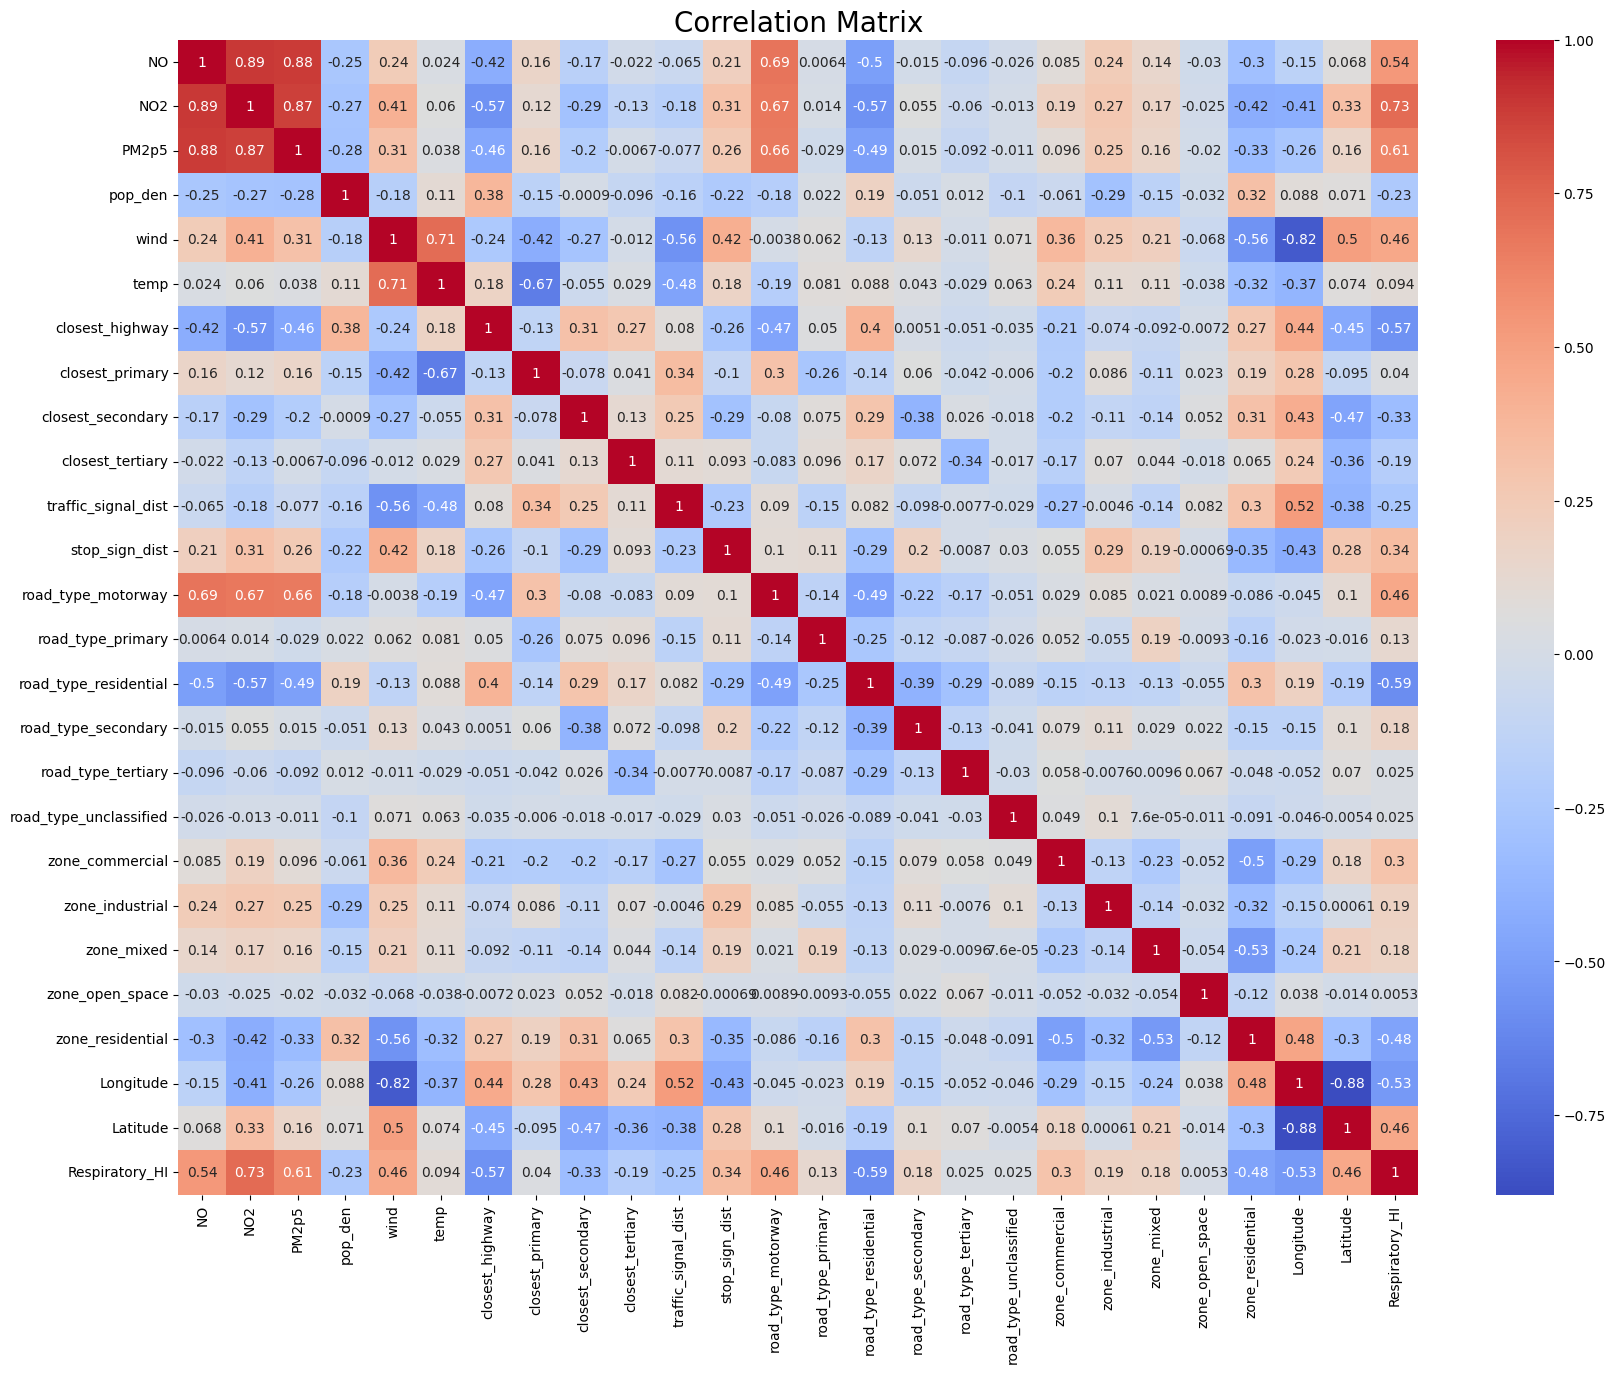

In [90]:
fig, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(vis_df[numerical].corr(), annot=True, cmap='coolwarm')
ax.set_title('Correlation Matrix', fontsize=20)
plt.show()

In [92]:
corr = pd.DataFrame(vis_df[numerical].corr()['Respiratory_HI'].sort_values(ascending=False))
corr = corr.iloc[1:,:]
corr.columns = ['Correlation']
corr

Correlation
NO2                        0.728081
PM2p5                      0.613451
NO                         0.535749
Latitude                   0.462277
road_type_motorway         0.459102
wind                       0.458172
stop_sign_dist             0.341605
zone_commercial            0.300532
zone_industrial            0.192210
zone_mixed                 0.183287
road_type_secondary        0.175741
road_type_primary          0.129546
temp                       0.094374
closest_primary            0.040298
road_type_unclassified     0.025229
road_type_tertiary         0.024695
zone_open_space            0.005282
closest_tertiary          -0.190022
pop_den                   -0.230703
traffic_signal_dist       -0.252191
closest_secondary         -0.326690
zone_residential          -0.479285
Longitude                 -0.534230
closest_highway           -0.566463
road_type_residential     -0.592468

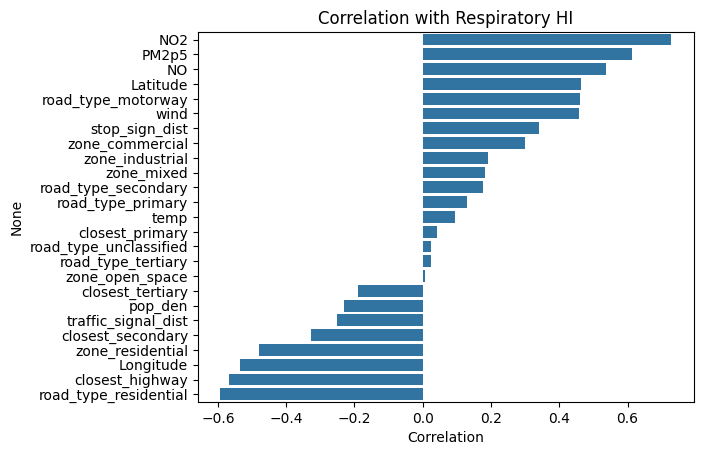

In [93]:
corr_bar = sns.barplot(x='Correlation', y=corr.index, data=corr)
corr_bar.set_title('Correlation with Respiratory HI')
plt.show()

## 4.2. Map

In [94]:
vis_geo = oakland_geo_1.copy()

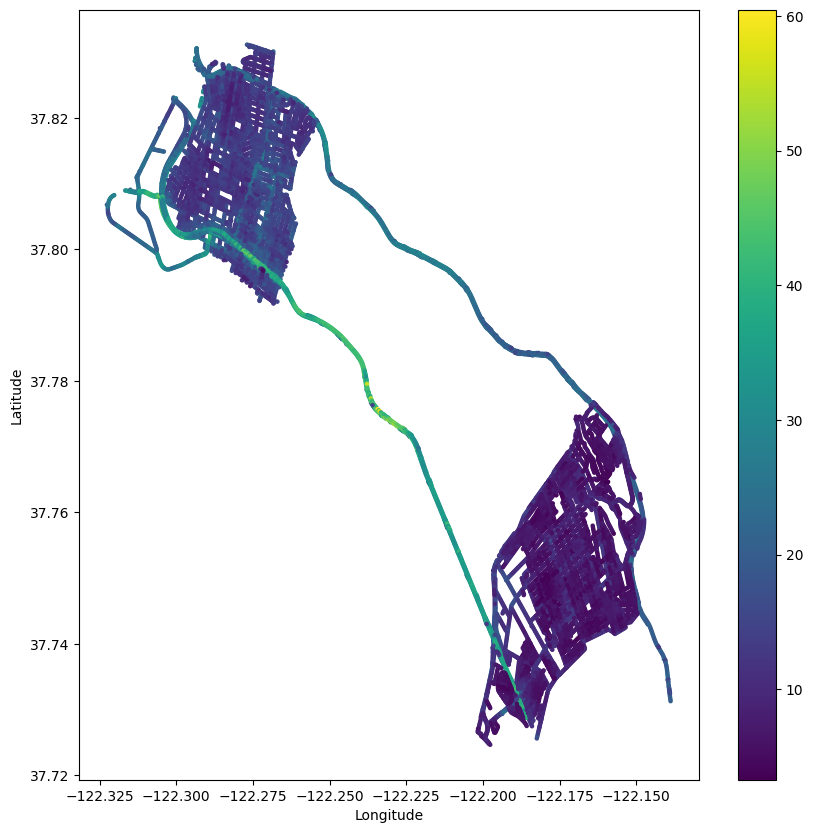

In [96]:
# NO2
plt.figure(figsize=(10,10))
plt.scatter(vis_geo.Longitude, vis_geo.Latitude, s=5, c=vis_geo.NO2)
plt.colorbar()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

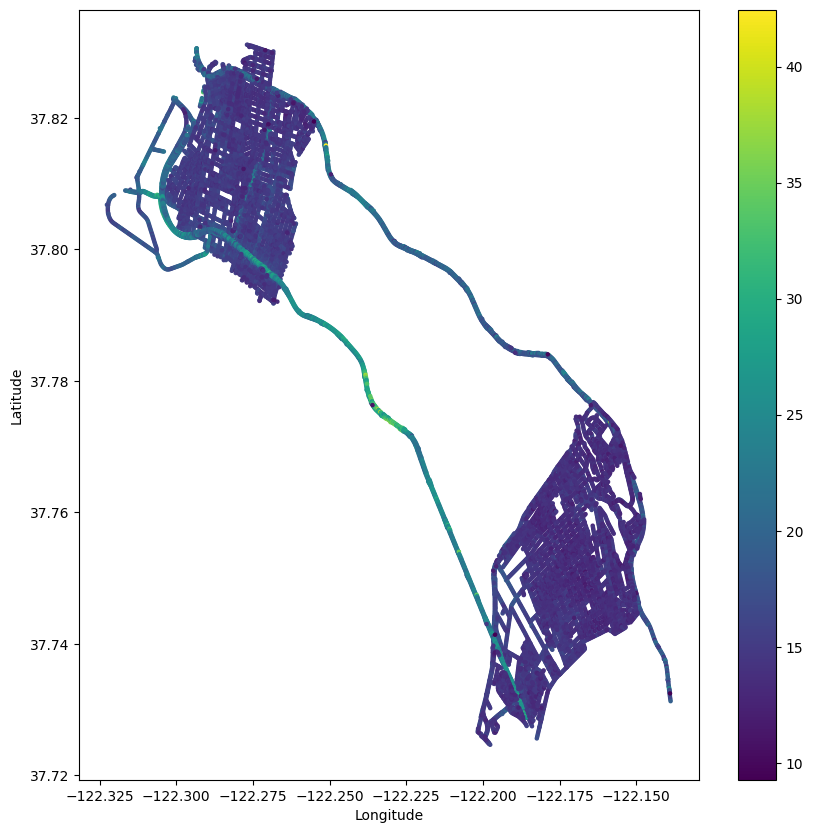

In [97]:
# PM2p5
plt.figure(figsize=(10,10))
plt.scatter(vis_geo.Longitude, vis_geo.Latitude, s=5, c=vis_geo.PM2p5)
plt.colorbar()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

## 4.3. Boxplot

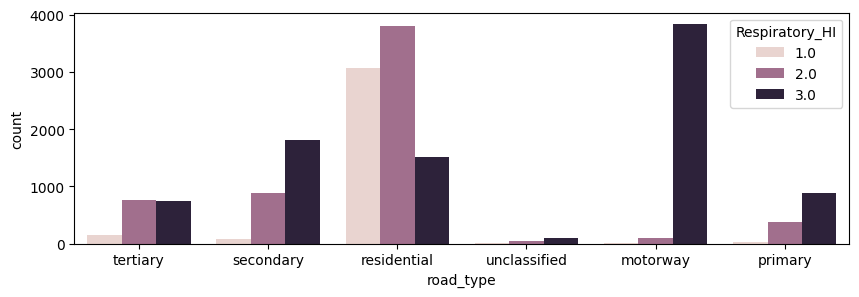

In [101]:
# By roads
plt.figure(figsize=(10,3))
sns.countplot(x='road_type', hue=vis_df['Respiratory_HI'], data=vis_df)
plt.show()

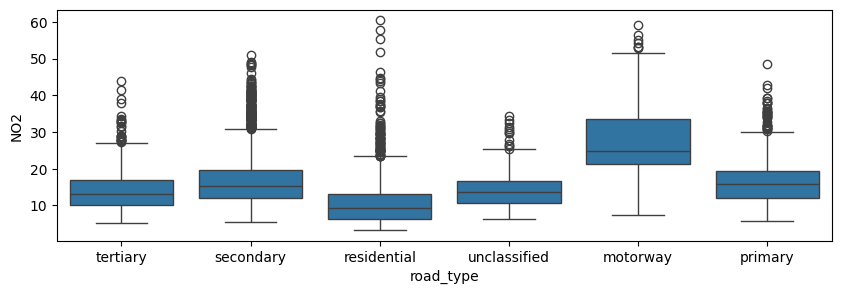

In [102]:
# NO2 by road
plt.figure(figsize=(10,3))
sns.boxplot(x='road_type', y='NO2', data=vis_df)
plt.show()

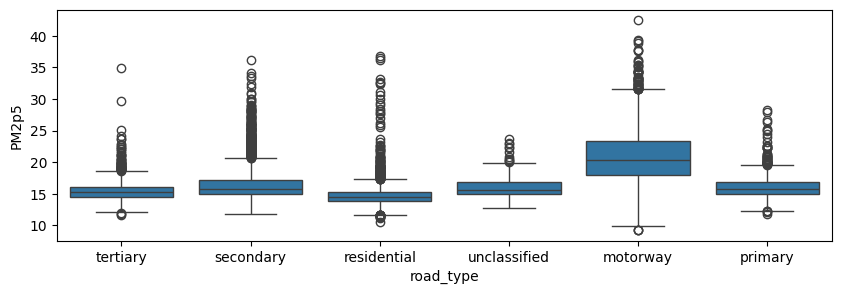

In [103]:
# PM2p5 by road
plt.figure(figsize=(10,3))
sns.boxplot(x='road_type', y='PM2p5', data=vis_df)
plt.show()

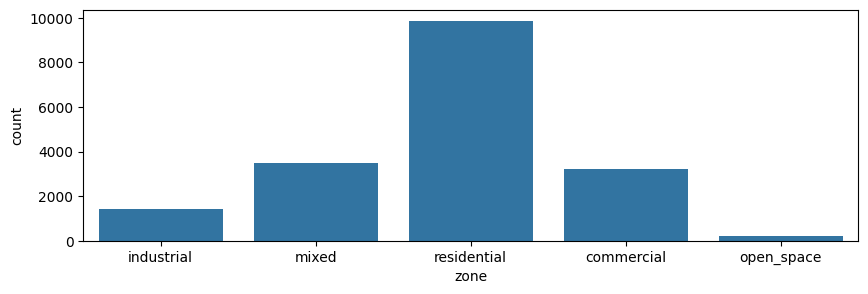

In [104]:
# By zones
plt.figure(figsize=(10,3))
sns.countplot(x='zone', data=vis_df)
plt.show()

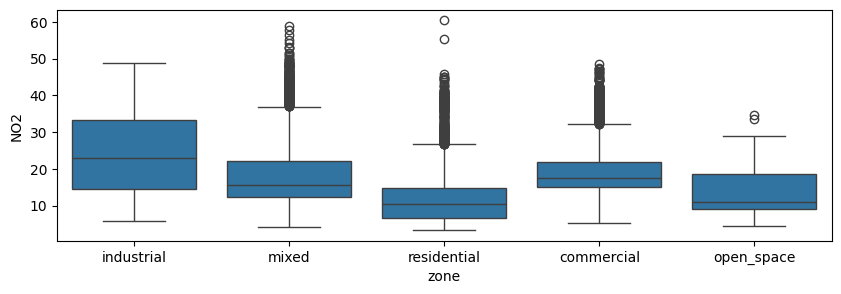

In [105]:
# NO2 by zones
plt.figure(figsize=(10,3))
sns.boxplot(x='zone', y='NO2', data=vis_df)
plt.show()

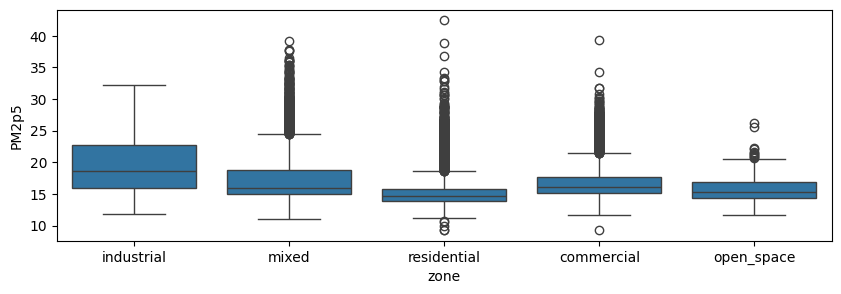

In [106]:
# PM2p5 by zones
plt.figure(figsize=(10,3))
sns.boxplot(x='zone', y='PM2p5', data=vis_df)
plt.show()

## 4.4. Distance

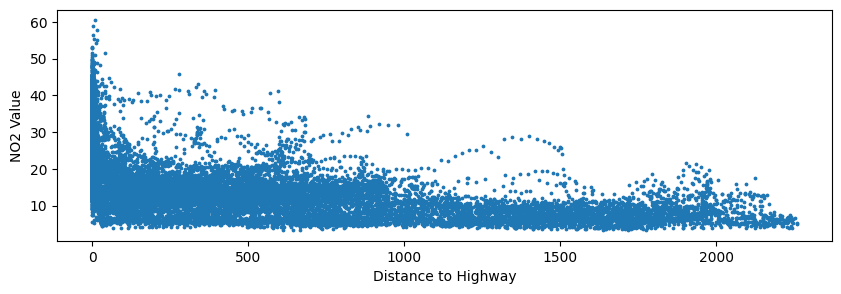

In [108]:
# NO2
plt.figure(figsize=(10,3))
plt.scatter(vis_df['closest_highway'], vis_df['NO2'], s=3)
plt.xlabel('Distance to Highway')
plt.ylabel('NO2 Value')
plt.show()

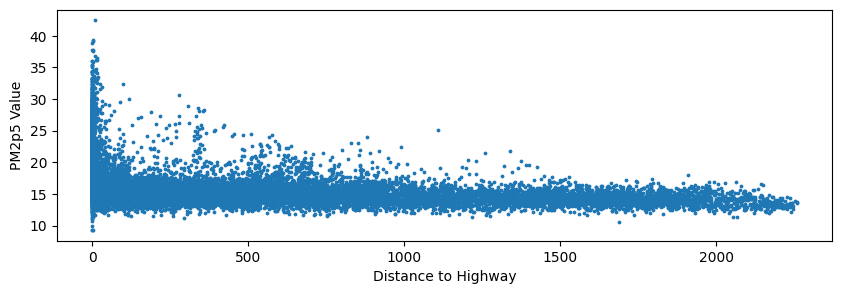

In [127]:
# PM2p5
plt.figure(figsize=(10,3))
plt.scatter(vis_df['closest_highway'], vis_df['PM2p5'], s=3)
plt.xlabel('Distance to Highway')
plt.ylabel('PM2p5 Value')
plt.show()

# 5. Model

In [110]:
model_df = oakland_geo_1.copy()

In [111]:
X = model_df[numerical].drop(['Respiratory_HI', 'Longitude', 'Latitude', 'road_type_unclassified', 'NO', 'NO2', 'PM2p5'], axis=1)

## 5.1. NO2

In [113]:
y_NO2 = model_df['NO2']

X_train_NO2, X_test_NO2, y_train_NO2, y_test_NO2 = train_test_split(X, y_NO2, test_size=0.25, random_state=1)
print(X_train_NO2.shape, X_test_NO2.shape, y_train_NO2.shape, y_test_NO2.shape)

(13662, 19) (4555, 19) (13662,) (4555,)


### 5.1.1. Bagging

In [117]:
# Random forest
forest = RandomForestRegressor(n_jobs=2)
params = {'max_features': [6, 8, 10], 'n_estimators': [150, 200]}

forest_NO2 = model_selection.GridSearchCV(forest, params, cv=5, scoring='neg_mean_squared_error')
forest_NO2.fit(X_train_NO2, y_train_NO2)

GridSearchCV(cv=5, estimator=RandomForestRegressor(n_jobs=2),
             param_grid={'max_features': [6, 8, 10],
                         'n_estimators': [150, 200]},
             scoring='neg_mean_squared_error')

In [119]:
print(np.sqrt(np.abs(forest_NO2.best_score_)))
print(forest_NO2.best_estimator_)

2.2750460761926274
RandomForestRegressor(max_features=10, n_estimators=200, n_jobs=2)


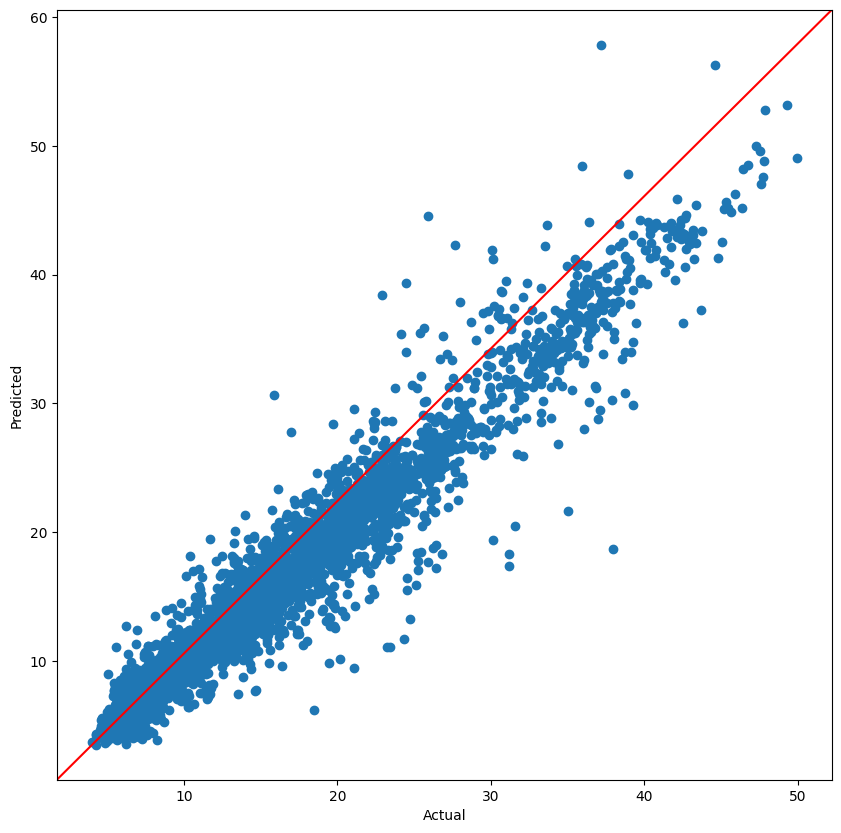

In [128]:
fig = plt.figure(figsize=(10, 10))
forest_pred_NO2 = forest_no2.predict(X_test_NO2)
plt.scatter(forest_pred_NO2, y_test_NO2)
plt.plot([0, 1], [0, 1], color='red', transform=plt.gca().transAxes)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

In [157]:
fi_rf_NO2 = pd.DataFrame({'feature': X_train_NO2.columns, 'importance': forest_NO2.best_estimator_.feature_importances_})
fi_rf_NO2 = fi_rf_NO2.sort_values(by='importance', ascending=False)
fi_rf_NO2

feature  importance
3         closest_highway    0.317565
9      road_type_motorway    0.164744
1                    wind    0.141092
2                    temp    0.064690
11  road_type_residential    0.060568
0                 pop_den    0.043098
4         closest_primary    0.040504
18       zone_residential    0.031991
6        closest_tertiary    0.031914
5       closest_secondary    0.031818
8          stop_sign_dist    0.029619
7     traffic_signal_dist    0.022868
15        zone_industrial    0.007320
14        zone_commercial    0.004671
16             zone_mixed    0.003565
12    road_type_secondary    0.001896
10      road_type_primary    0.001321
13     road_type_tertiary    0.000661
17        zone_open_space    0.000095

### 5.1.2. Boosting

In [131]:
gb = GradientBoostingRegressor()

params = {'max_features': [6, 8, 10], 'learning_rate': [0.05, 0.1, 0.5], 'n_estimators': [150, 200]}

gb_NO2 = model_selection.GridSearchCV(gb, params, cv=5, scoring='neg_mean_squared_error')
gb_NO2.fit(X_train_NO2, y_train_NO2)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(),
             param_grid={'learning_rate': [0.05, 0.1, 0.5],
                         'max_features': [6, 8, 10],
                         'n_estimators': [150, 200]},
             scoring='neg_mean_squared_error')

In [132]:
print(np.sqrt(np.abs(gb_NO2.best_score_)))
print(gb_NO2.best_estimator_)

2.917115405721512
GradientBoostingRegressor(learning_rate=0.5, max_features=10, n_estimators=200)


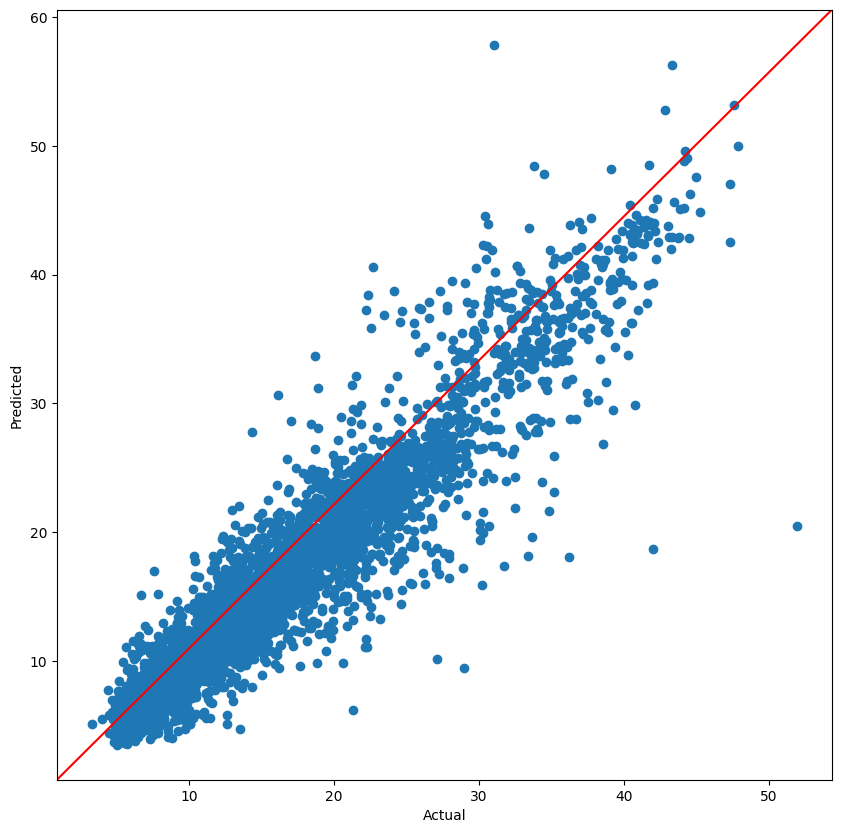

In [133]:
fig = plt.figure(figsize=(10, 10))
gb_pred_NO2 = gb_NO2.predict(X_test_NO2)
plt.scatter(gb_pred_NO2, y_test_NO2)
plt.plot([0, 1], [0, 1], color='red', transform=plt.gca().transAxes)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

In [158]:
fi_gb_NO2 = pd.DataFrame({'feature': X_train_NO2.columns, 'importance': gb_NO2.best_estimator_.feature_importances_})
fi_gb_NO2 = fi_gb_NO2.sort_values(by='importance', ascending=False)
fi_gb_NO2

feature  importance
3         closest_highway    0.538856
1                    wind    0.173224
2                    temp    0.061953
0                 pop_den    0.045794
9      road_type_motorway    0.028950
11  road_type_residential    0.027787
5       closest_secondary    0.024808
6        closest_tertiary    0.024386
4         closest_primary    0.022009
8          stop_sign_dist    0.017172
7     traffic_signal_dist    0.012416
18       zone_residential    0.011929
12    road_type_secondary    0.003556
16             zone_mixed    0.002544
15        zone_industrial    0.001979
14        zone_commercial    0.001225
10      road_type_primary    0.001060
13     road_type_tertiary    0.000225
17        zone_open_space    0.000126

### 5.1.3. Permutation Importance

In [165]:
pi_NO2 = permutation_importance(forest_NO2.best_estimator_, X_test_NO2, y_test_NO2, n_repeats=5, random_state=1)

pi_NO2_r = pd.DataFrame({'feature': X_train_NO2.columns, 'importance': pi_NO2.importances_mean})
pi_NO2_r = pi_NO2_r.sort_values(by='importance', ascending=False)
pi_NO2_r

feature  importance
3         closest_highway    0.501976
1                    wind    0.267504
9      road_type_motorway    0.131002
2                    temp    0.089828
4         closest_primary    0.060251
0                 pop_den    0.044602
5       closest_secondary    0.041570
11  road_type_residential    0.039311
8          stop_sign_dist    0.031367
6        closest_tertiary    0.029287
7     traffic_signal_dist    0.021322
18       zone_residential    0.016324
16             zone_mixed    0.004474
15        zone_industrial    0.004010
14        zone_commercial    0.003493
12    road_type_secondary    0.000804
10      road_type_primary    0.000371
13     road_type_tertiary    0.000355
17        zone_open_space    0.000013

In [166]:
# Summary

summary_NO2 = pd.DataFrame({'RF': list(fi_rf_NO2['feature']), 'GB': list(fi_gb_NO2['feature']), 'PI': list(pi_NO2_r['feature'])})
summary_NO2

RF                     GB                     PI
0         closest_highway        closest_highway        closest_highway
1      road_type_motorway                   wind                   wind
2                    wind                   temp     road_type_motorway
3                    temp                pop_den                   temp
4   road_type_residential     road_type_motorway        closest_primary
5                 pop_den  road_type_residential                pop_den
6         closest_primary      closest_secondary      closest_secondary
7        zone_residential       closest_tertiary  road_type_residential
8        closest_tertiary        closest_primary         stop_sign_dist
9       closest_secondary         stop_sign_dist       closest_tertiary
10         stop_sign_dist    traffic_signal_dist    traffic_signal_dist
11    traffic_signal_dist       zone_residential       zone_residential
12        zone_industrial    road_type_secondary             zone_mixed
13        zone_commercial             zone_mixed        zone_industrial
14             zone_mixed        zone_industrial        zone_commercial
15    road_type_secondary        zone_commercial    road_type_secondary
16      road_type_primary      road_type_primary      road_type_primary
17     road_type_tertiary     road_type_tertiary     road_type_tertiary
18        zone_open_space        zone_open_space        zone_open_space

## 5.2. PM2p5

In [114]:
y_PM2p5 = model_df['PM2p5']

X_train_PM2p5, X_test_PM2p5, y_train_PM2p5, y_test_PM2p5 = train_test_split(X, y_PM2p5, test_size=0.25, random_state=1)
print(X_train_PM2p5.shape, X_test_PM2p5.shape, y_train_PM2p5.shape, y_test_PM2p5.shape)

(13662, 19) (4555, 19) (13662,) (4555,)


### 5.2.1. Bagging

In [177]:
forest = RandomForestRegressor(n_jobs=2)
params = {'max_features': [6, 8, 10], 'n_estimators': [150, 200, 250]}

forest_PM2p5 = model_selection.GridSearchCV(forest, params, cv=5, scoring='neg_mean_squared_error')
forest_PM2p5.fit(X_train_PM2p5, y_train_PM2p5)

GridSearchCV(cv=5, estimator=RandomForestRegressor(n_jobs=2),
             param_grid={'max_features': [6, 8, 10],
                         'n_estimators': [150, 200, 250]},
             scoring='neg_mean_squared_error')

In [178]:
print(np.sqrt(np.abs(forest_PM2p5.best_score_)))
print(forest_PM2p5.best_estimator_)

1.39695712125566
RandomForestRegressor(max_features=8, n_estimators=200, n_jobs=2)


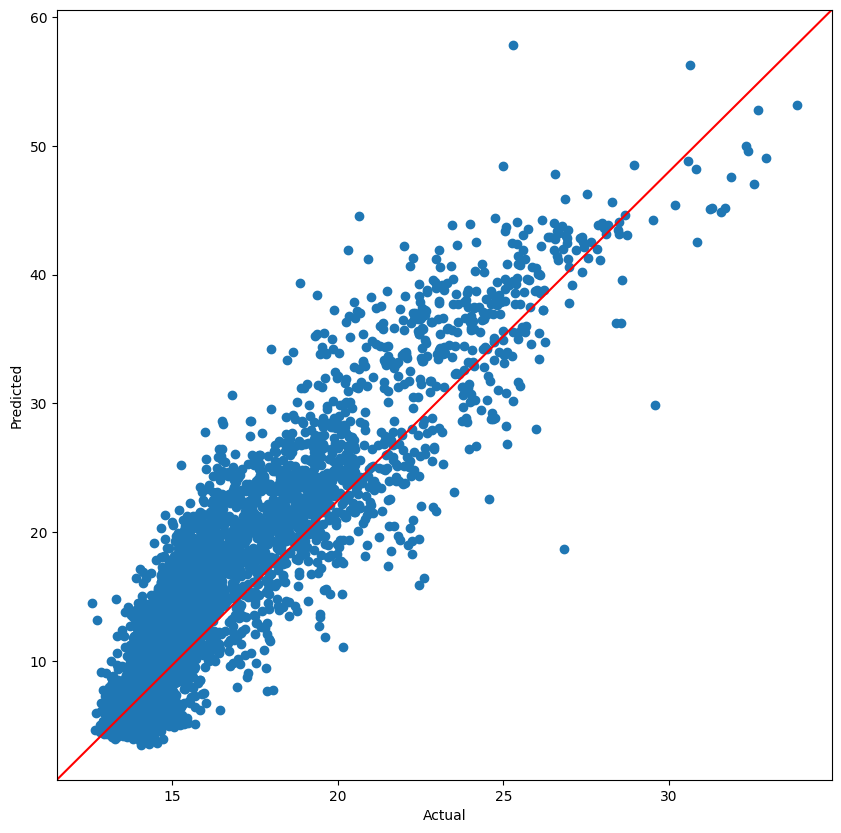

In [179]:
fig = plt.figure(figsize=(10, 10))
forest_pred_PM2p5 = forest_PM2p5.predict(X_test_PM2p5)
plt.scatter(forest_pred_PM2p5, y_test_NO2)
plt.plot([0, 1], [0, 1], color='red', transform=plt.gca().transAxes)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

In [180]:
fi_rf_PM2p5 = pd.DataFrame({'feature': X_train_PM2p5.columns, 'importance': forest_PM2p5.best_estimator_.feature_importances_})
fi_rf_PM2p5 = fi_rf_PM2p5.sort_values(by='importance', ascending=False)
fi_rf_PM2p5

feature  importance
9      road_type_motorway    0.242173
3         closest_highway    0.207058
1                    wind    0.103912
4         closest_primary    0.062046
2                    temp    0.053549
6        closest_tertiary    0.052698
0                 pop_den    0.049969
11  road_type_residential    0.049967
5       closest_secondary    0.049136
8          stop_sign_dist    0.047553
7     traffic_signal_dist    0.035769
18       zone_residential    0.020842
15        zone_industrial    0.007385
16             zone_mixed    0.007061
14        zone_commercial    0.005831
12    road_type_secondary    0.003615
10      road_type_primary    0.000624
13     road_type_tertiary    0.000521
17        zone_open_space    0.000291

### 5.2.2. Boosting

In [171]:
gb = GradientBoostingRegressor()

params = {'max_features': [6, 8, 10], 'learning_rate': [0.05, 0.1, 0.5], 'n_estimators': [150, 200]}

gb_PM2p5 = model_selection.GridSearchCV(gb, params, cv=5, scoring='neg_mean_squared_error')
gb_PM2p5.fit(X_train_PM2p5, y_train_PM2p5)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(),
             param_grid={'learning_rate': [0.05, 0.1, 0.5],
                         'max_features': [6, 8, 10],
                         'n_estimators': [150, 200]},
             scoring='neg_mean_squared_error')

In [172]:
print(np.sqrt(np.abs(gb_PM2p5.best_score_)))
print(gb_PM2p5.best_estimator_)

1.591736430830939
GradientBoostingRegressor(learning_rate=0.5, max_features=8, n_estimators=200)


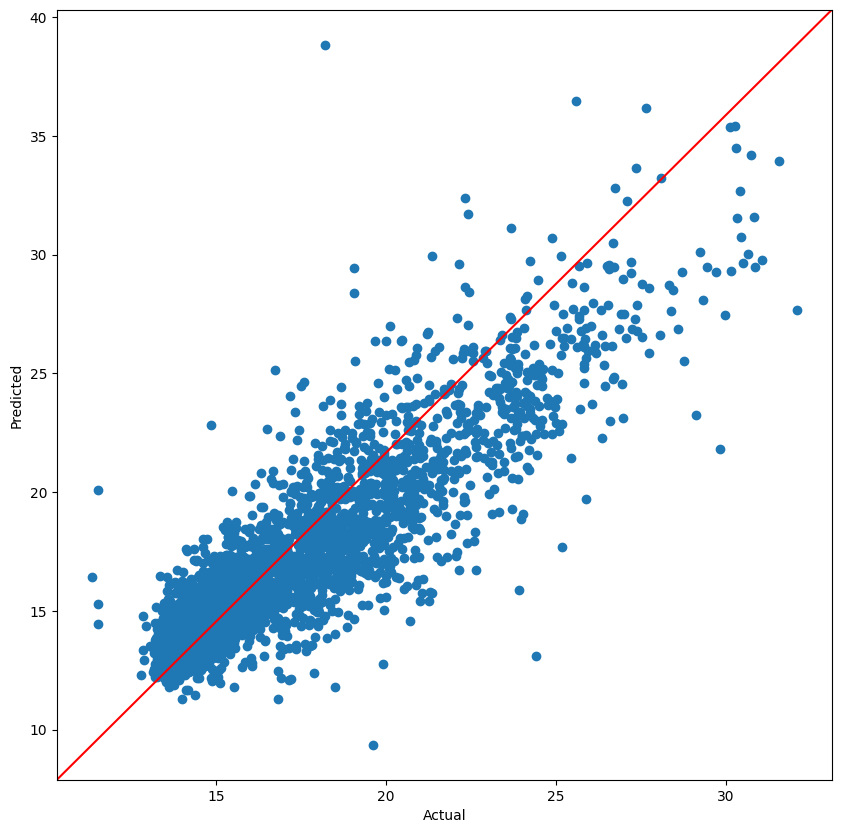

In [173]:
fig = plt.figure(figsize=(10, 10))
gb_pred_PM2p5 = gb_PM2p5.predict(X_test_PM2p5)
plt.scatter(gb_pred_PM2p5, y_test_PM2p5)
plt.plot([0, 1], [0, 1], color='red', transform=plt.gca().transAxes)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

In [174]:
fi_gb_PM2p5 = pd.DataFrame({'feature': X_train_PM2p5.columns, 'importance': gb_PM2p5.best_estimator_.feature_importances_})
fi_gb_PM2p5 = fi_gb_PM2p5.sort_values(by='importance', ascending=False)
fi_gb_PM2p5

feature  importance
9      road_type_motorway    0.401470
1                    wind    0.178301
3         closest_highway    0.132609
5       closest_secondary    0.061715
4         closest_primary    0.042133
2                    temp    0.036010
6        closest_tertiary    0.031278
0                 pop_den    0.025726
11  road_type_residential    0.025171
8          stop_sign_dist    0.023242
7     traffic_signal_dist    0.011226
15        zone_industrial    0.009634
16             zone_mixed    0.008869
14        zone_commercial    0.007532
18       zone_residential    0.002554
12    road_type_secondary    0.001220
10      road_type_primary    0.000848
13     road_type_tertiary    0.000338
17        zone_open_space    0.000124

### 5.2.3. Permutation Importance

In [175]:
pi_PM2p5 = permutation_importance(forest_PM2p5.best_estimator_, X_test_PM2p5, y_test_PM2p5, n_repeats=5, random_state=1)

pi_PM2p5_r = pd.DataFrame({'feature': X_train_PM2p5.columns, 'importance': pi_PM2p5.importances_mean})
pi_PM2p5_r = pi_PM2p5_r.sort_values(by='importance', ascending=False)
pi_PM2p5_r

feature  importance
3         closest_highway    0.305873
9      road_type_motorway    0.252672
1                    wind    0.188675
2                    temp    0.065695
4         closest_primary    0.062422
0                 pop_den    0.045912
6        closest_tertiary    0.035129
8          stop_sign_dist    0.033040
5       closest_secondary    0.032219
11  road_type_residential    0.026551
7     traffic_signal_dist    0.019219
18       zone_residential    0.017261
16             zone_mixed    0.006558
15        zone_industrial    0.002306
14        zone_commercial    0.002255
12    road_type_secondary    0.000923
10      road_type_primary    0.000394
13     road_type_tertiary    0.000103
17        zone_open_space   -0.000082

In [181]:
# Summary

summary_PM2p5 = pd.DataFrame({'RF': list(fi_rf_PM2p5['feature']), 'GB': list(fi_gb_PM2p5['feature']), 'PI': list(pi_PM2p5_r['feature'])})
summary_PM2p5

RF                     GB                     PI
0      road_type_motorway     road_type_motorway        closest_highway
1         closest_highway                   wind     road_type_motorway
2                    wind        closest_highway                   wind
3         closest_primary      closest_secondary                   temp
4                    temp        closest_primary        closest_primary
5        closest_tertiary                   temp                pop_den
6                 pop_den       closest_tertiary       closest_tertiary
7   road_type_residential                pop_den         stop_sign_dist
8       closest_secondary  road_type_residential      closest_secondary
9          stop_sign_dist         stop_sign_dist  road_type_residential
10    traffic_signal_dist    traffic_signal_dist    traffic_signal_dist
11       zone_residential        zone_industrial       zone_residential
12        zone_industrial             zone_mixed             zone_mixed
13             zone_mixed        zone_commercial        zone_industrial
14        zone_commercial       zone_residential        zone_commercial
15    road_type_secondary    road_type_secondary    road_type_secondary
16      road_type_primary      road_type_primary      road_type_primary
17     road_type_tertiary     road_type_tertiary     road_type_tertiary
18        zone_open_space        zone_open_space        zone_open_space